In [2]:
import operator
import random

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

In [14]:
# Set the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Randomly sample 10% of the training set
train_size = len(trainset)
train_indices = random.sample(range(train_size), int(train_size * 1.0))
train_subset = Subset(trainset, train_indices)

# Randomly sample 10% of the test set
test_size = len(testset)
test_indices = random.sample(range(test_size), int(test_size * 1.0))
test_subset = Subset(testset, test_indices)

# Create data loaders for the subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 46196886.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


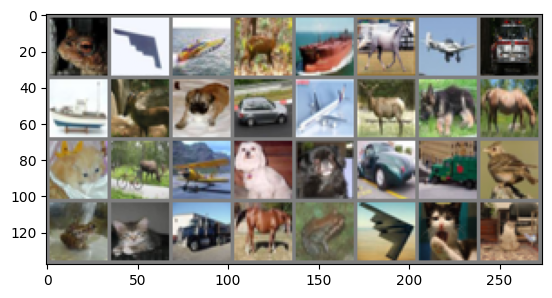

frog  plane ship  deer  ship  horse plane truck ship  deer  dog   car   plane deer  dog   horse cat   deer  plane dog   dog   car   truck bird  frog  cat   truck horse frog  plane cat   cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.optim as optim

# Simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
set_seed(0)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
import torch.nn.functional as F

n_labels_total = 3000
sampled_thus_far = 1000 # initial number of labeled samples
k = 200  # batch size for active learning

# Helper function to train the model
def train_model(net, trainloader, criterion, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Helper function to evaluate the model
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

Epoch 1, Loss: 2.3042720407247543
Epoch 2, Loss: 2.3037059903144836
Epoch 3, Loss: 2.3029895797371864
Epoch 4, Loss: 2.3018887042999268
Epoch 5, Loss: 2.301124982535839
Epoch 6, Loss: 2.301530845463276
Epoch 7, Loss: 2.3002180010080338
Epoch 8, Loss: 2.3002310171723366
Epoch 9, Loss: 2.299478217959404
Epoch 10, Loss: 2.2984778359532356
Epoch 11, Loss: 2.2987610697746277
Epoch 12, Loss: 2.2997104972600937
Epoch 13, Loss: 2.297472409904003
Epoch 14, Loss: 2.2973893508315086
Epoch 15, Loss: 2.2963038235902786
Epoch 16, Loss: 2.2960951700806618
Epoch 17, Loss: 2.2956516444683075
Epoch 18, Loss: 2.29439078271389
Epoch 19, Loss: 2.2920262068510056
Epoch 20, Loss: 2.2916166931390762
Epoch 21, Loss: 2.2908972278237343
Epoch 22, Loss: 2.288623698055744
Epoch 23, Loss: 2.2863109931349754
Epoch 24, Loss: 2.2845649868249893
Epoch 25, Loss: 2.28294288367033
Epoch 26, Loss: 2.280051976442337
Epoch 27, Loss: 2.2764702290296555
Epoch 28, Loss: 2.2727275639772415
Epoch 29, Loss: 2.263633169233799
Epoch

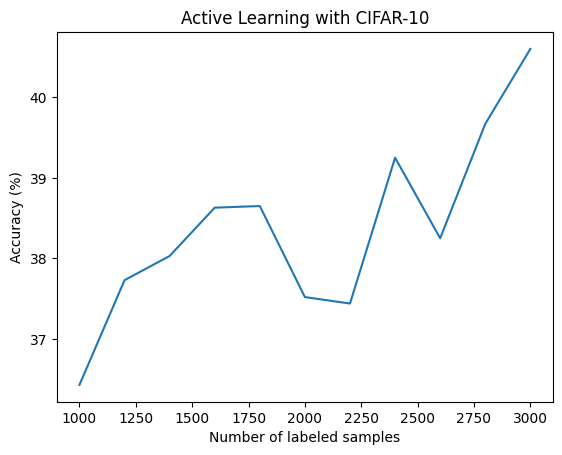

In [17]:
# n_labels_total = 3000
# sampled_thus_far = 1000 # initial number of labeled samples
# k = 200  # batch size for active learning

# Initialize pool indices and initial training indices
pool_indices = list(range(len(trainset)))
cur_train_indices = pool_indices[:sampled_thus_far]
pool_indices = pool_indices[sampled_thus_far:]

# Initial training set and loader
trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                          batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model initially
train_model(net, trainloader, criterion, optimizer, epochs=100)
initial_score = evaluate_model(net, testloader)
print(initial_score)

num_labels = [sampled_thus_far]  # x-axis for learning curve
scores = [initial_score]  # y-axis for learning curve

while sampled_thus_far < n_labels_total:
    cur_sample = random.sample(pool_indices, k)
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)

    # Update trainloader with new data
    trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                              batch_size=batch_size, shuffle=True, num_workers=2)

    # Train and evaluate the model
    train_model(net, trainloader, criterion, optimizer, epochs=10)
    score = evaluate_model(net, testloader)

    num_labels.append(len(cur_train_indices))
    scores.append(score)
    sampled_thus_far += k
    print(score)

# Plot learning curve
plt.plot(num_labels, scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

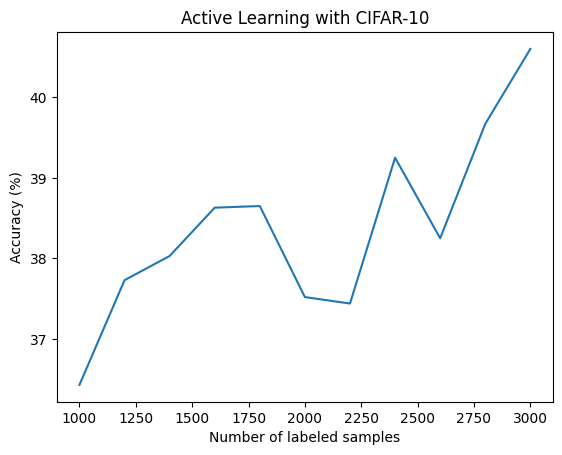

In [18]:
# Plot learning curve
plt.plot(num_labels, scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()

In [49]:
import torch.nn.functional as F

n_labels_total = 3000
sampled_thus_far = 1000 # initial number of labeled samples
k = 200  # batch size for active learning

# Helper function to train the model
def train_model(net, trainloader, criterion, optimizer, epochs=1):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Helper function to evaluate the model
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [50]:
set_seed(0)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 1, Loss: 2.3042720407247543
Epoch 2, Loss: 2.3037059903144836
Epoch 3, Loss: 2.3029895797371864
Epoch 4, Loss: 2.3018887042999268
Epoch 5, Loss: 2.301124982535839
Epoch 6, Loss: 2.301530845463276
Epoch 7, Loss: 2.3002180010080338
Epoch 8, Loss: 2.3002310171723366
Epoch 9, Loss: 2.299478217959404
Epoch 10, Loss: 2.2984778359532356
Epoch 11, Loss: 2.2987610697746277
Epoch 12, Loss: 2.2997104972600937
Epoch 13, Loss: 2.297472409904003
Epoch 14, Loss: 2.2973893508315086
Epoch 15, Loss: 2.2963038235902786
Epoch 16, Loss: 2.2960951700806618
Epoch 17, Loss: 2.2956516444683075
Epoch 18, Loss: 2.29439078271389
Epoch 19, Loss: 2.2920262068510056
Epoch 20, Loss: 2.2916166931390762
Epoch 21, Loss: 2.2908972278237343
Epoch 22, Loss: 2.288623698055744
Epoch 23, Loss: 2.2863109931349754
Epoch 24, Loss: 2.2845649868249893
Epoch 25, Loss: 2.28294288367033
Epoch 26, Loss: 2.280051976442337
Epoch 27, Loss: 2.2764702290296555
Epoch 28, Loss: 2.2727275639772415
Epoch 29, Loss: 2.263633169233799
Epoch

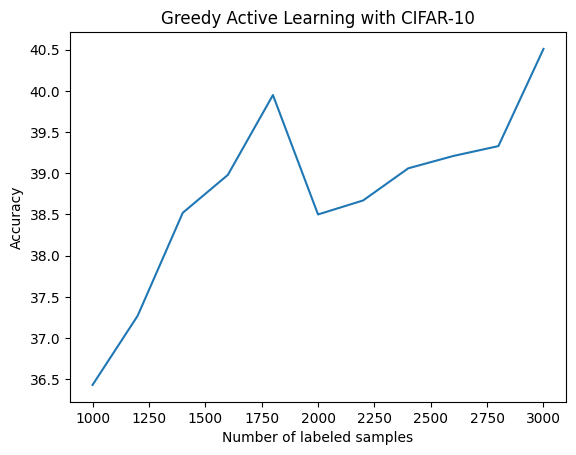

In [51]:
# n_labels_total = 50
# sampled_thus_far = 10  # initial number of labeled samples
# k = 20  # batch size for active learning

# Initialize pool indices and initial training indices
pool_indices = list(range(len(trainset)))
cur_train_indices = pool_indices[:sampled_thus_far]
pool_indices = pool_indices[sampled_thus_far:]

# # Helper function to train the model
# def train_model(net, trainloader, criterion, optimizer, epochs=1):
#     net.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in trainloader:
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# # Helper function to evaluate the model
# def evaluate_model(net, testloader):
#     net.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             outputs = net(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return 100 * correct / total

# Initial training set and loader
trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                          batch_size=batch_size, shuffle=True, num_workers=2)

# Train the model initially
train_model(net, trainloader, criterion, optimizer, epochs=100)
initial_score = evaluate_model(net, testloader)
print(initial_score)

num_labels = [sampled_thus_far]  # x-axis for learning curve
active_scores = [initial_score]  # y-axis for learning curve

while sampled_thus_far < n_labels_total:
    # predict all probabilities
    pool_subset = Subset(trainset, pool_indices)
    pool_loader = torch.utils.data.DataLoader(pool_subset, batch_size=batch_size, shuffle=True, num_workers=2)

    indices_to_probs = {}
    with torch.no_grad():
        counter = 0
        for batch_idx, (inputs, _) in enumerate(pool_loader):
            counter += 1
            if counter == 10000:
                break
            batch_start_idx = batch_idx * batch_size
            batch_indices = pool_indices[batch_start_idx:batch_start_idx + batch_size]

            outputs = net(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probs, 1)

            for i, idx in enumerate(batch_indices):
                uncertainty = abs(max_probs[i].item())
                indices_to_probs[idx] = uncertainty

    # rank instances!
    sorted_indices = sorted(indices_to_probs, key=indices_to_probs.get, reverse=False)
    # take top k
    cur_sample = sorted_indices[:k]

    # remove these so we don't sample again! and
    # add to train/pool sample
    for idx in cur_sample:
        pool_indices.remove(idx)
        cur_train_indices.append(idx)

    # Update trainloader with new data
    trainloader = torch.utils.data.DataLoader(Subset(trainset, cur_train_indices),
                                              batch_size=batch_size, shuffle=True, num_workers=2)

    # Train and evaluate the model
    train_model(net, trainloader, criterion, optimizer, epochs=10)
    score = evaluate_model(net, testloader)

    num_labels.append(len(cur_train_indices))
    active_scores.append(score)
    sampled_thus_far += k
    print(score)

# Plot learning curve
plt.plot(num_labels, active_scores)
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy')
plt.title('Greedy Active Learning with CIFAR-10')
plt.show()

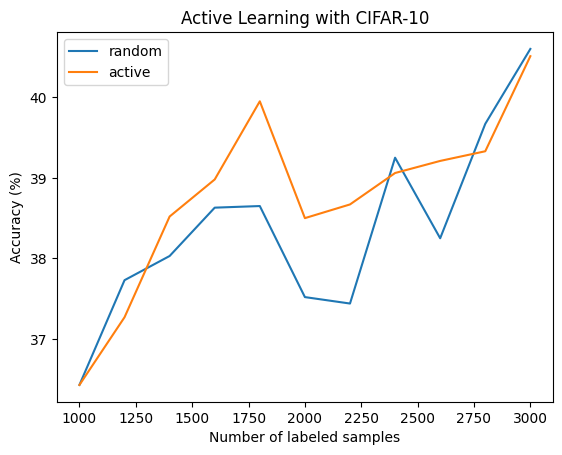

In [52]:
# plot together
plt.plot(num_labels, scores, label='random')
plt.plot(num_labels, active_scores, label='active')
plt.legend(loc="upper left");
plt.xlabel('Number of labeled samples')
plt.ylabel('Accuracy (%)')
plt.title('Active Learning with CIFAR-10')
plt.show()